In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import numpy.polynomial.polynomial as poly

import statistics
import warnings
import itertools
import sqlite3

In [2]:
db = sqlite3.connect('results.sqlite3')

In [3]:
def fetch_run(names_or_ids):
    run_info, grouped, cals = [], {}, {}
    for name_or_id in names_or_ids:
        if type(name_or_id) is str:
            runs = db.execute('SELECT run_id FROM runs WHERE name LIKE ?', (run_name,)).fetchall()
            if len(runs) > 1:
                raise ValueError('Ambiguous run name {} matches run ids {}'.format(run_name, runs))

            ((run_id,),), run_name = runs, name_or_id
        else:
            run_id, (run_name,) = name_or_id, db.execute('SELECT name FROM runs WHERE run_id == ?', (name_or_id,)).fetchone()
        run_info.append((run_id, run_name))
    
        data = db.execute('''
            SELECT channel, duty_cycle, voltage, voltage_stdev FROM measurements
            WHERE run_id == ?
            ORDER BY channel ASC, duty_cycle ASC;
            ''', (run_id,)).fetchall()
        _ch, cal_duty, *cal = data[0]
        assert cal_duty == 0
        cals[run_id] = cal
        for ch, data in itertools.groupby(data, lambda elem: elem[0]):
            if ch == -1: # skip cal data
                continue
            if ch in grouped:
                warnings.warn('Duplicate data: Channel {} found in more than one run!'.format(ch))
            grouped[ch] = [(duty, volt, stdev) for _ch, duty, volt, stdev in data]
    return run_info, grouped, next(iter(cals.values())) # for now just use some random cal value

In [12]:
def plot_run(figtitle, *names_or_ids, combine_plots=False):
    run_info, data, cal = fetch_run(names_or_ids)
    
    if combine_plots:
        rows, cols = 1, 1
    else:
        rows = (len(data)+1)//2
        cols = 2 if len(data) > 1 else 1
    fig, axs = plt.subplots(rows, cols, figsize=(16,5*max(2, rows)), squeeze=False)
    fig.suptitle(figtitle)
    if combine_plots:
        axs = np.array([axs[0,0]] * len(names_or_ids))

    cal_volt, cal_stdev = cal
    offsets = []
    for ch, ax in zip(data, axs.flat):
        ch_data = data[ch]
        duty, volt, stdev = zip(*ch_data)
        
        duty = np.array(duty) / duty[0]
        volt = np.array(volt) - cal_volt
        vref = volt[0]
        stdev = np.array(stdev)
        
        max_y = max(volt)/vref
        min_x, max_x = min(duty), max(duty)
        
        offx, slope = fit_coefs = poly.polyfit(duty, volt, 1)
        fit_func = poly.polyval(duty, fit_coefs)
        ax.errorbar(duty, volt/vref, yerr=stdev/vref)
        ax.plot(duty, fit_func/vref)
        
        ax.set_xscale('log')
        ax.set_yscale('log')
        bit_offx = offx/slope
        offsets.append(bit_offx)
        print('Channel {} offset: {:6.3f}lsb'.format(ch, bit_offx))
        ax.set_title('Channel {}, offset={:.3f}lsb'.format(ch, bit_offx))
    
        # reuse latest duty cycles here
        ax.set_xticks(duty)
        ax.set_xticklabels([str(i) for i in range(len(duty))])
        ax.set_xlabel('bit index')
        ax.set_yticks([2**i for i in range(len(duty))])
        ax.set_yticklabels([str(2**i) for i in range(len(duty))])

        ax.set_xlim([min_x*0.9, max_x*1.1])
        ax.set_ylim([0, max_y*1.1])
    if len(names_or_ids) > 1:
        print('Offset statistics: mean={:.4f}lsb, stdev={:.4f}lsb'.format(
            statistics.mean(offsets), statistics.stdev(offsets)))

In [5]:
def fetch_runs(*names):
    return [run_id for name in names for run_id, in db.execute('''
    SELECT DISTINCT runs.run_id
    FROM runs JOIN measurements USING (run_id)
    WHERE name LIKE ? AND channel != -1
    ''', (name,)).fetchall() ]

Channel 28 offset:  2.643lsb
Channel 29 offset:  2.616lsb
Channel 30 offset:  2.633lsb
Channel 31 offset:  2.681lsb
Offset statistics: mean=2.6432lsb, stdev=0.0276lsb


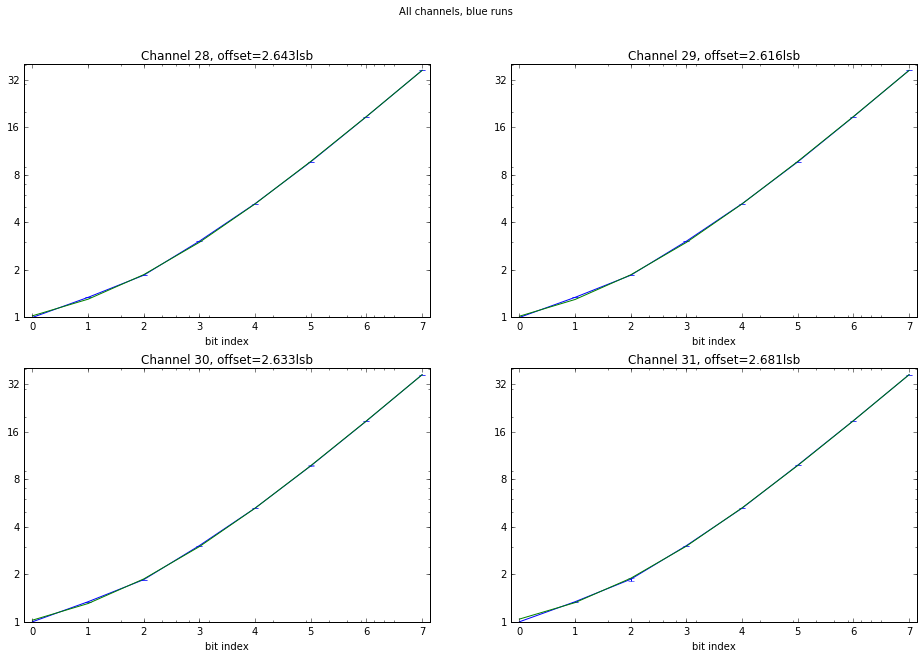

In [6]:
plot_run('All channels, blue runs', *fetch_runs('green1', 'green2', 'green3', 'green4'))

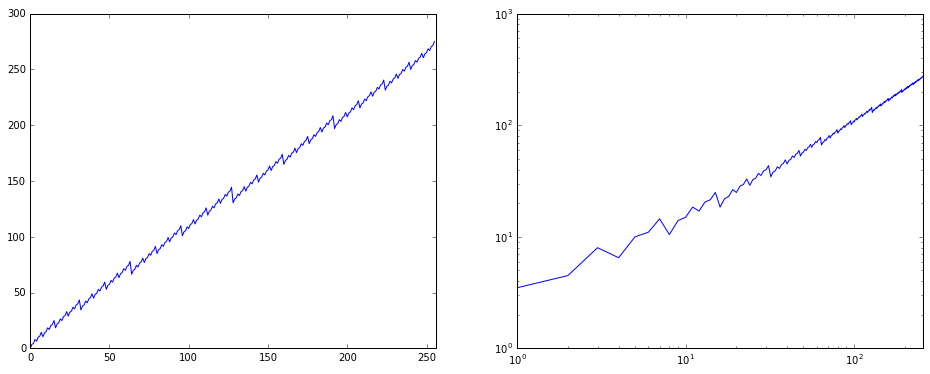

In [7]:
def bitslide(nbits, offx_lsb):
    return [ sum((2**n + offx_lsb) if i&(2**n) else 0 for n in range(nbits)) for i in range(2**nbits) ]

def plot_bitslide(data):
    fig, (axl, axr) = plt.subplots(1, 2, figsize=(16, 6))
    axl.plot(data)
    axr.plot(data)
    axr.set_yscale('log')
    axr.set_xscale('log')
    axl.set_xlim((0, len(data)))
    axr.set_xlim((0, len(data)))

plot_bitslide(bitslide(8, 2.5))

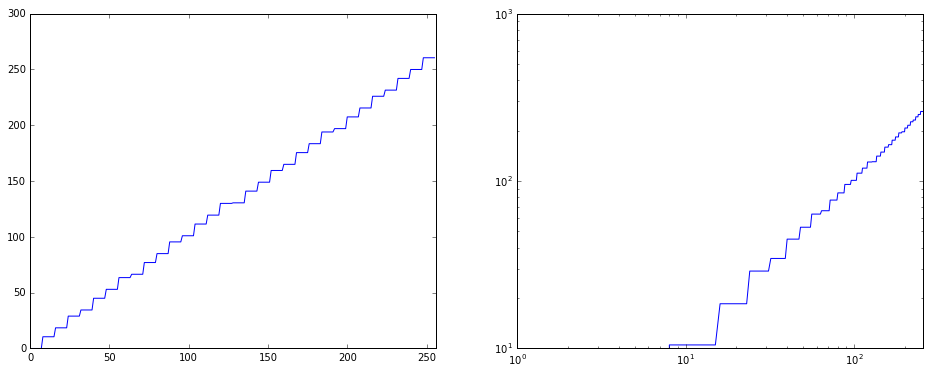

In [8]:
def cutoff_reference(nbits, offx_lsb, cutoff):
    return [ sum((2**n + offx_lsb) if i&(2**n) else 0 for n in range(cutoff, nbits))
            for i in range(2**nbits) ]

plot_bitslide(cutoff_reference(8, 2.5, 3))

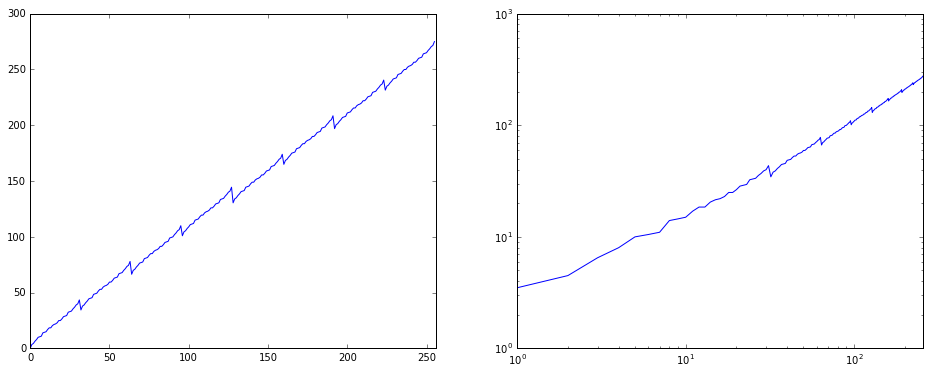

In [9]:
def improved_bitslide1(nbits, offx_lsb, cutoff):
    bs = sorted(bitslide(cutoff, offx_lsb))
    return [ sum((2**n + offx_lsb) if i&(2**n) else 0 for n in range(cutoff, nbits))
            + bs[i%(2**cutoff)] for i in range(2**nbits) ]

plot_bitslide(improved_bitslide1(8, 2.5, 5))

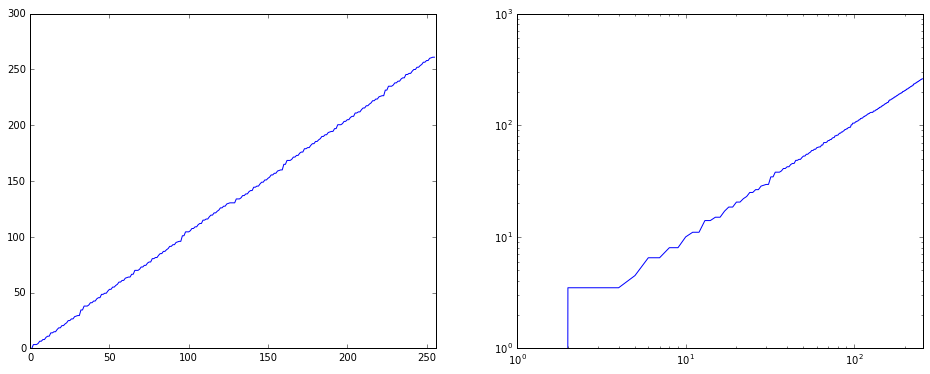

In [10]:
def improved_bitslide2(nbits, offx_lsb, cutoff):
    bs = lambda x: min(bitslide(cutoff, offx_lsb), key=lambda y: abs(x-y))
    return [ sum((2**n + offx_lsb) if i&(2**n) else 0 for n in range(cutoff, nbits))
            + bs(i%(2**cutoff)) for i in range(2**nbits) ]

plot_bitslide(improved_bitslide2(8, 2.5, 5))

Channel 23 offset:  0.974lsb


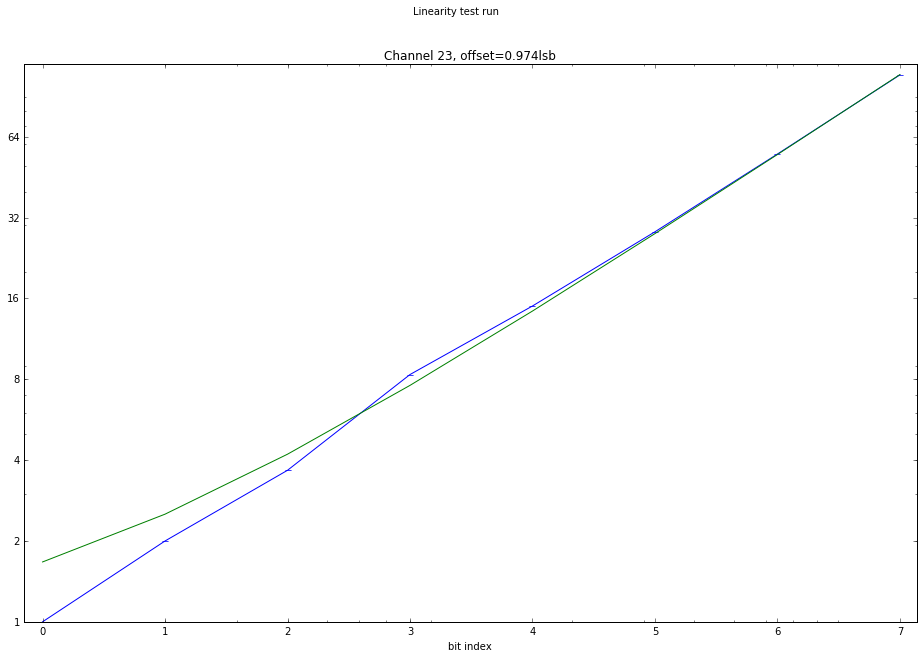

In [27]:
plot_run('Linearity test run', *fetch_runs('test89'))